# Customer Churn Prediction

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE


In [2]:
# Load data
data = pd.read_csv('Telco-Customer-Churn.csv')

# Data Cleaning
# Convert 'Churn' column to numeric
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})

# Convert 'TotalCharges' to numeric, coerce errors to NaN
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# Fill missing values in 'TotalCharges' with the median
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

# Convert other categorical columns to numeric using one-hot encoding
categorical_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
                       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 
                       'PaperlessBilling', 'PaymentMethod']
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Drop columns not needed for prediction
data = data.drop(['customerID'], axis=1)

# Handle missing values in 'tenure' and 'MonthlyCharges' if any
data = data.dropna()


In [3]:
# Split the data into training and testing sets
X = data.drop('Churn', axis=1)
y = data['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


                                       importance
TotalCharges                             0.167863
tenure                                   0.152460
MonthlyCharges                           0.135874
PaymentMethod_Electronic check           0.102262
InternetService_Fiber optic              0.051667
Contract_Two year                        0.040288
PaperlessBilling_Yes                     0.038654
gender_Male                              0.023598
MultipleLines_Yes                        0.022507
Contract_One year                        0.021620
Partner_Yes                              0.019283
StreamingMovies_Yes                      0.018601
OnlineBackup_Yes                         0.017826
PaymentMethod_Credit card (automatic)    0.017276
OnlineSecurity_Yes                       0.017264
StreamingTV_Yes                          0.017055
DeviceProtection_Yes                     0.016616
Dependents_Yes                           0.016158
TechSupport_Yes                          0.015923


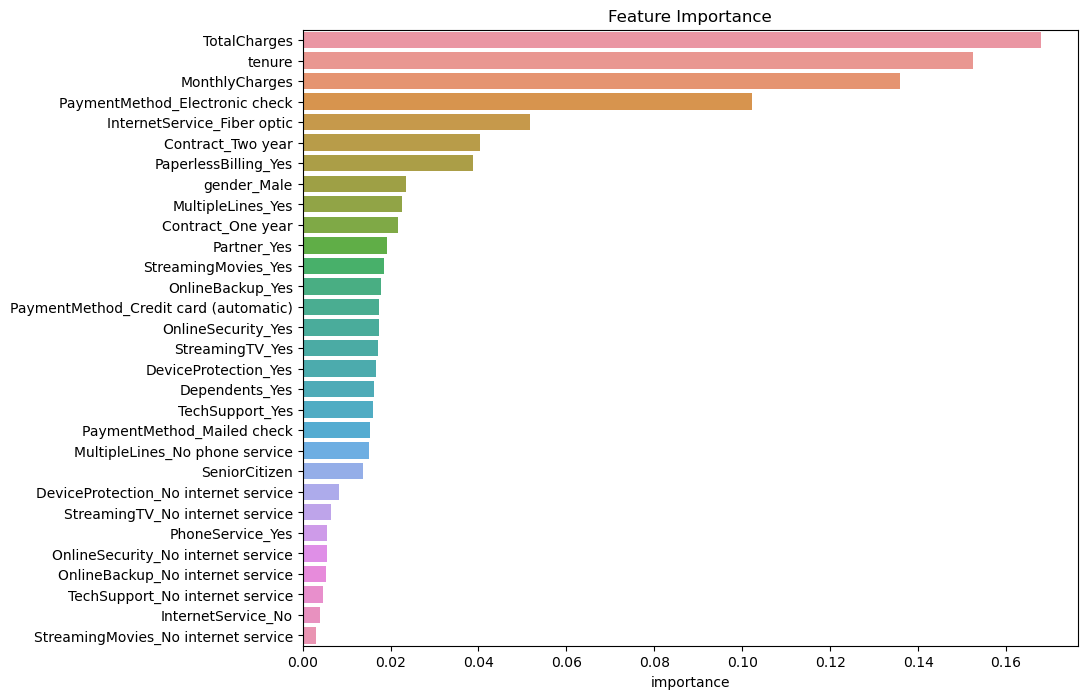

In [4]:
# Fit Random Forest model to calculate feature importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)

# Get feature importances
feature_importances = pd.DataFrame(rf_model.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

# Display feature importances
print(feature_importances)

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances['importance'], y=feature_importances.index)
plt.title('Feature Importance')
plt.show()


Logistic Regression Results
Accuracy: 0.7875059157595835
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1539
           1       0.60      0.66      0.63       574

    accuracy                           0.79      2113
   macro avg       0.73      0.75      0.74      2113
weighted avg       0.80      0.79      0.79      2113

______________________________________________________
SVM Results
Accuracy: 0.6805489824893516
              precision    recall  f1-score   support

           0       0.82      0.72      0.77      1539
           1       0.43      0.59      0.50       574

    accuracy                           0.68      2113
   macro avg       0.63      0.65      0.63      2113
weighted avg       0.72      0.68      0.69      2113

______________________________________________________
Random Forest Results
Accuracy: 0.7884524372929484
              precision    recall  f1-score   support

           0       0.85      0.8

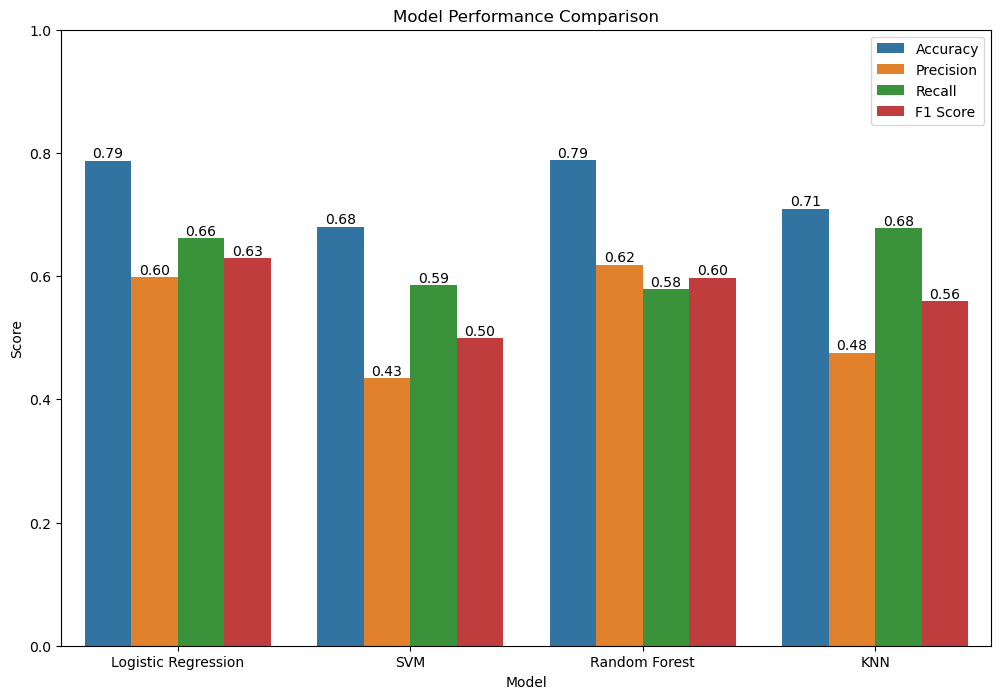

In [8]:
# Initialize models with class weight adjustment where applicable
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000, class_weight='balanced'),
    'SVM': SVC(class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced'),
    'KNN': KNeighborsClassifier()
}

# Train and evaluate models
metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

for name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test)
    metrics['Model'].append(name)
    metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['Precision'].append(precision_score(y_test, y_pred, zero_division=1))
    metrics['Recall'].append(recall_score(y_test, y_pred))
    metrics['F1 Score'].append(f1_score(y_test, y_pred, zero_division=1))
    print(f"{name} Results")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, zero_division=1))
    print("______________________________________________________")

metrics_df = pd.DataFrame(metrics)

# Plot metrics
metrics_melted = metrics_df.melt(id_vars=['Model'], value_vars=['Accuracy', 'Precision', 'Recall', 'F1 Score'], 
                                 var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_melted)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.2f')
plt.legend(loc='best')
plt.show()


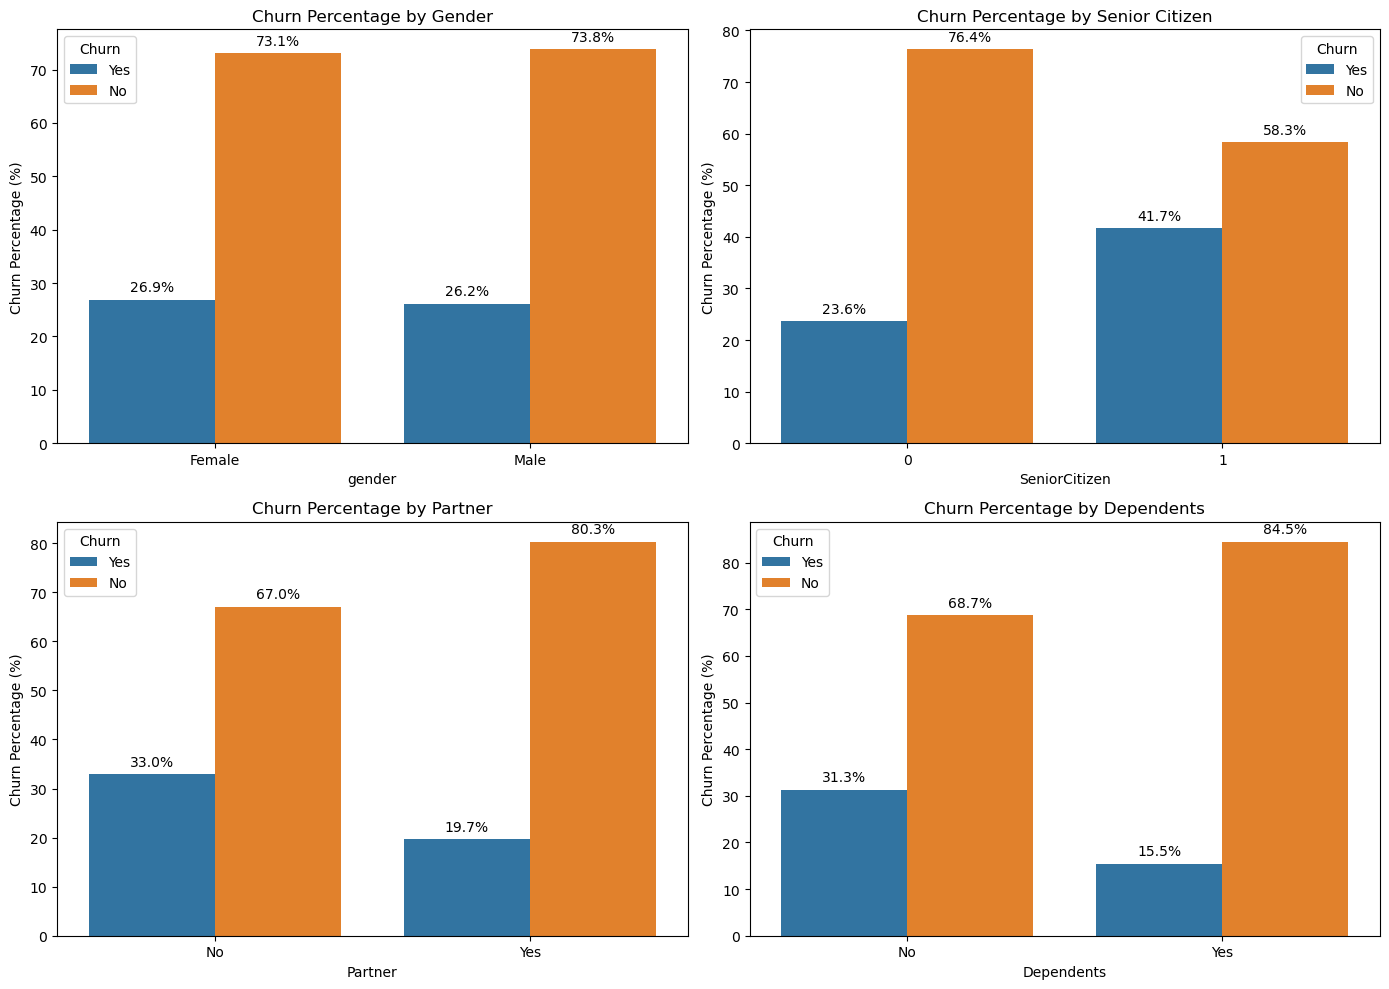

In [9]:
# Load data again for EDA (without dropping 'TotalCharges' and 'customerID')
data = pd.read_csv('Telco-Customer-Churn.csv')

# Group data and calculate percentages
def calculate_churn_percentage(column):
    churn_counts = data.groupby([column, 'Churn']).size().unstack().fillna(0)
    churn_percentages = churn_counts.div(churn_counts.sum(axis=1), axis=0) * 100
    churn_percentages = churn_percentages.reset_index()
    churn_percentages = churn_percentages.melt(id_vars=[column], value_vars=['Yes', 'No'], var_name='Churn', value_name='Percentage')
    return churn_percentages

# Calculate churn percentages
churn_percentage_gender = calculate_churn_percentage('gender')
churn_percentage_senior_citizen = calculate_churn_percentage('SeniorCitizen')
churn_percentage_partner = calculate_churn_percentage('Partner')
churn_percentage_dependents = calculate_churn_percentage('Dependents')

# Plot churn percentages
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Function to annotate bar plots with percentages
def annotate_bars(ax):
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}%', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points')

# Gender
sns.barplot(x='gender', y='Percentage', hue='Churn', data=churn_percentage_gender, ax=axes[0, 0])
axes[0, 0].set_title('Churn Percentage by Gender')
axes[0, 0].set_ylabel('Churn Percentage (%)')
annotate_bars(axes[0, 0])

# Senior Citizen
sns.barplot(x='SeniorCitizen', y='Percentage', hue='Churn', data=churn_percentage_senior_citizen, ax=axes[0, 1])
axes[0, 1].set_title('Churn Percentage by Senior Citizen')
axes[0, 1].set_ylabel('Churn Percentage (%)')
axes[0, 1].set_xticklabels(['0', '1'])
annotate_bars(axes[0, 1])

# Partner
sns.barplot(x='Partner', y='Percentage', hue='Churn', data=churn_percentage_partner, ax=axes[1, 0])
axes[1, 0].set_title('Churn Percentage by Partner')
axes[1, 0].set_ylabel('Churn Percentage (%)')
axes[1, 0].set_xticklabels(['No', 'Yes'])
annotate_bars(axes[1, 0])

# Dependents
sns.barplot(x='Dependents', y='Percentage', hue='Churn', data=churn_percentage_dependents, ax=axes[1, 1])
axes[1, 1].set_title('Churn Percentage by Dependents')
axes[1, 1].set_ylabel('Churn Percentage (%)')
axes[1, 1].set_xticklabels(['No', 'Yes'])
annotate_bars(axes[1, 1])

plt.tight_layout()
plt.show()
